# 1. Extract results

In [1]:
import sys

sys.path.append("../../")
from _analysis._rule_app_analysis import automatic_results, save_results_to_json

In [2]:
from typing import *
from _analysis._rule_app_analysis import load_database, coverage_rate

In [ ]:
base_path = "../../Data/Temp/Benchmark/"
test_types = ["Valid", "Test"]
temp_types = ["Raw", "Complete", "Hier"]
predict_types = ["fw", "bw"]
radius = [0, 1, 2, 3]
results = automatic_results(test_types, temp_types, predict_types, radius, base_path)

In [ ]:
save_results_to_json(results, "../../Data/Temp/Benchmark/raw_results.json")

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results["Valid"]["bw"])
results_df

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results["Test"]["fw"])
results_df

## 2. Barplot

In [7]:
import sys

sys.path.append("../../")
from _analysis._rule_app_analysis import load_results_from_json, save_results_to_json

results = load_results_from_json("../../Data/Temp/Benchmark/raw_results.json")

Results successfully loaded from ../../Data/Temp/Benchmark/raw_results.json


In [8]:
results

{'Valid': {'fw': {'Raw_0': [16.69, 7.86, 99.38],
   'Raw_1': [8.24, 7.24, 98.72],
   'Raw_2': [3.55, 6.5, 98.19],
   'Raw_3': [2.62, 4.92, 97.93],
   'Complete_0': [67.52, 94.5, 96.41],
   'Complete_1': [21.77, 92.92, 88.31],
   'Complete_2': [5.2, 88.6, 67.11],
   'Complete_3': [3.17, 78.03, 58.48],
   'Hier_0': [67.52, 94.5, 96.41],
   'Hier_1': [21.77, 92.92, 88.31],
   'Hier_2': [5.2, 88.6, 67.11],
   'Hier_3': [3.17, 78.03, 58.48]},
  'bw': {'Raw_0': [13.74, 7.86, 99.54],
   'Raw_1': [2.7, 7.24, 98.05],
   'Raw_2': [0.86, 6.5, 94.17],
   'Raw_3': [0.45, 4.92, 90.77],
   'Complete_0': [72.49, 93.46, 97.75],
   'Complete_1': [21.96, 92.84, 92.92],
   'Complete_2': [13.89, 88.5, 89.22],
   'Complete_3': [9.38, 77.97, 85.07],
   'Hier_0': [72.49, 93.46, 97.75],
   'Hier_1': [21.96, 92.84, 92.92],
   'Hier_2': [13.89, 88.5, 89.22],
   'Hier_3': [9.38, 77.97, 85.07]}},
 'Test': {'fw': {'Raw_0': [16.46, 7.92, 99.41],
   'Raw_1': [8.11, 7.7, 98.66],
   'Raw_2': [3.5, 6.62, 98.17],
   'Raw

In [9]:
import pandas as pd

valid = results["Valid"]
valid_fw = valid["fw"]
valid_bw = valid["bw"]
fw = pd.DataFrame(valid_fw).T
bw = pd.DataFrame(valid_bw).T
fw.rename(
    columns={
        0: "average_solution",
        # 1: r'\mathcal(C)',
        1: "C",
        2: "NR",
    },
    inplace=True,
)
bw.rename(
    columns={
        0: "average_solution",
        # 1: r'\mathcal(C)',
        1: "C",
        2: "NR",
    },
    inplace=True,
)

In [10]:
from _analysis._rule_app_analysis import plot_percentage
import matplotlib.pyplot as plt

In [ ]:
from typing import *
def plot_percentage(
    df: pd.DataFrame,
    ax: plt.Axes,
    column: str,
    title: str = "A",
    color_map: Optional[List[str]] = None,
    fontsettings: Optional[Dict[str, int]] = None,
) -> None:
    """
    Plot a percentage bar chart for different categories and subcategories within the data.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data to plot. Index of the DataFrame
                       should be string labels in the format 'category_subcategory'.
    ax (plt.Axes): Matplotlib Axes object where the chart will be drawn.
    column (str): Column name in df that contains the percentage values to plot.
    title (str, optional): Title of the plot. Default is 'A'.
    color_map (List[str], optional): List of hex color strings for the bars. If None,
                                     a default set of colors will be used.
    fontsettings (Dict[str, int], optional): Dictionary containing font size settings
                                             for various elements of the plot. If None,
                                             default settings are applied.

    Returns:
    None: This function does not return any value but modifies the ax object by drawing a bar chart.

    Example:
    >>> fig, ax = plt.subplots()
    >>> data = pd.DataFrame({'Value': [20, 30, 40, 50]}, index=['Type1_10', 'Type1_20', 'Type2_10', 'Type2_20'])
    >>> plot_percentage(data, ax, 'Value')
    >>> plt.show()
    """
    if fontsettings is None:
        fontsettings = {
            "title_size": 18,
            "label_size": 16,
            "ticks_size": 16,
            "annotation_size": 12,
        }

    # Split the index into template type and radii
    df["Type"] = [i.split("_")[0] for i in df.index]
    df["Radii"] = [int(i.split("_")[1]) for i in df.index]

    # Sort data to group by type and then by radii
    df = df.sort_values(by=["Radii"])

    # Prepare color map for radii using coolwarm
    if color_map is None:
        color_map = ["#3A8EBA", "#92C5DE", "#F4A582", "#D6604D"]

    # Plotting logic with annotations
    total_width = 3  # Total width for group
    width = total_width / len(
        df["Radii"].unique()
    )  # Width for each bar within each type group
    type_positions = np.arange(len(df["Type"].unique())) * (
        len(df["Radii"].unique()) + 1
    )

    for i, t in enumerate(df["Type"].unique()):
        for j, r in enumerate(df["Radii"].unique()):
            # print(t)
            bar_positions = type_positions[i] + j * width
            heights = df[(df["Type"] == t) & (df["Radii"] == r)][column]
            ax.bar(
                bar_positions,
                heights,
                width=width,
                label=f"$R_{{{r}}}$" if i == 0 else "",
                color=color_map[j % len(color_map)],
            )
    # Adding annotations
    for rect in ax.patches:
        height = rect.get_height()
        ax.annotate(
            f"{height:.1f}%",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=fontsettings["annotation_size"],
        )

    # Enhancements like axes labeling, ticks setting, and adding grid
    ax.set_ylabel(rf"$\mathcal{{{column}}} (\%)$", fontsize=fontsettings["label_size"])
    ax.set_title(title, fontsize=fontsettings["title_size"], weight="medium")
    ax.set_xticks(type_positions + total_width / 2 - width / 2)
    ax.set_xticklabels(
        [f"$Q_{{\\text{{{t}}}}}$" for t in df["Type"].unique()],
        fontsize=fontsettings["ticks_size"],
    )
    ax.set_yticks(np.arange(0, 101, 20))
    ax.set_yticklabels(
        [f"{i}%" for i in range(0, 101, 20)], fontsize=fontsettings["ticks_size"]
    )
    ax.grid(True, which="major", linestyle="--", linewidth="0.5", color="grey")
    ax.set_axisbelow(True)

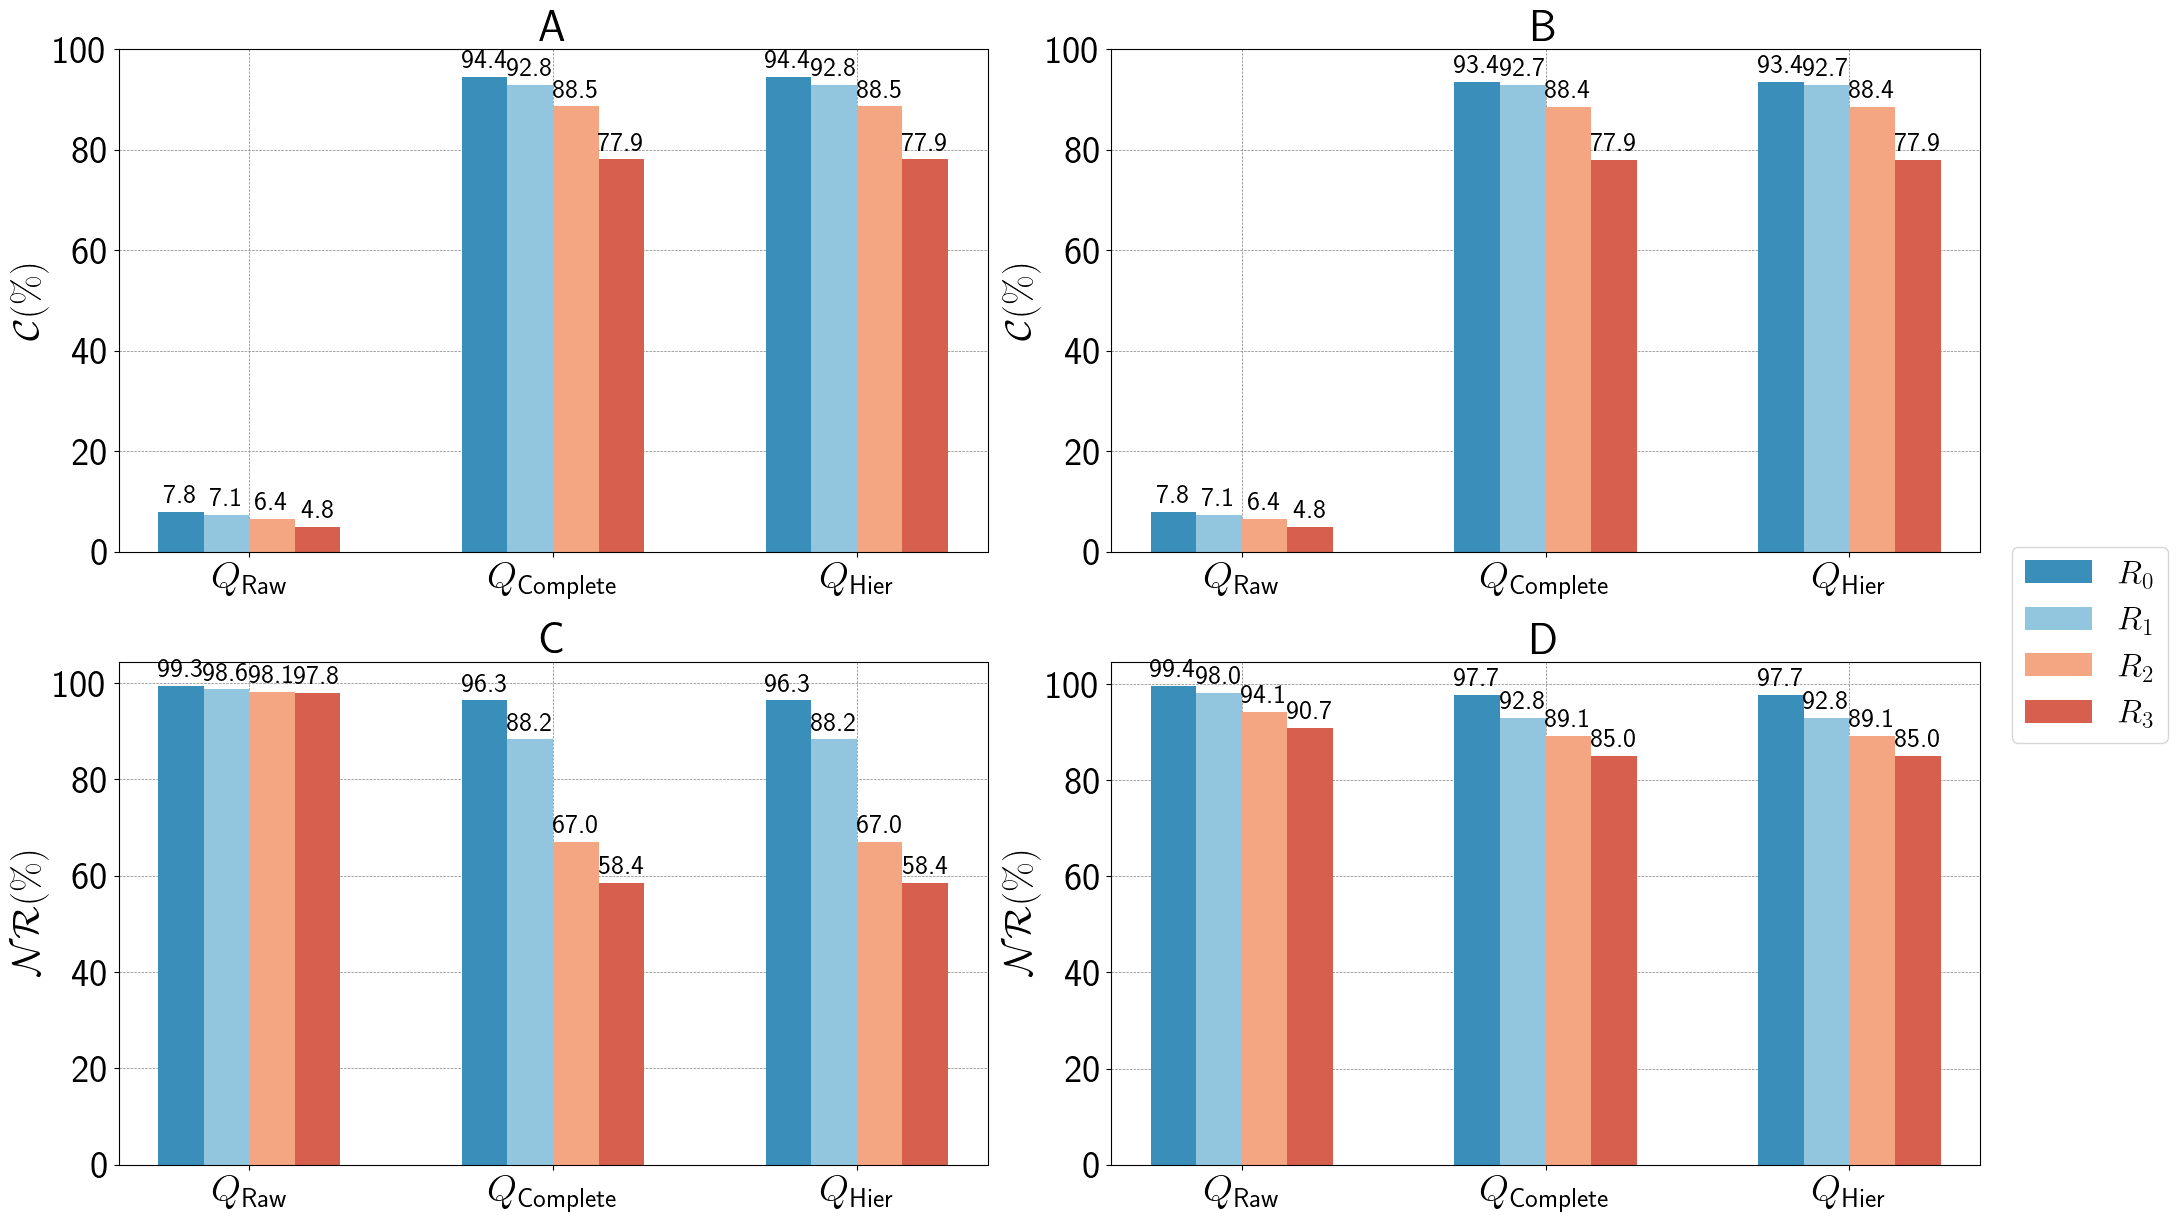

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Creating the figure and subplots
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")  # Ensure amsmath is loaded
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 13))
fontsettings = {
    "title_size": 32,
    "label_size": 28,
    "ticks_size": 28,
    "annotation_size": 20,
}

# Plotting data
plot_percentage(fw, ax1, "C", title=r"A", fontsettings=fontsettings)
plot_percentage(bw, ax2, "C", title=r"B", fontsettings=fontsettings)

plot_percentage(fw, ax3, "NR", title=r"C", fontsettings=fontsettings)
plot_percentage(bw, ax4, "NR", title=r"D", fontsettings=fontsettings)


fig.legend(
    [r"$R_0$", r"$R_1$", r"$R_2$", r"$R_3$"],  # Correct LaTeX formatted strings
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    ncol=1,
    fontsize=24,
    # bbox_to_anchor=(0.5, 0.001),
)

# Adjusting layout
fig.tight_layout()
fig.subplots_adjust(hspace=0.22, bottom=0.1)
fig.savefig(
    "./fig/Fig10_template_false_rate_compare_valid_new.pdf",
    dpi=600,
    bbox_inches="tight",
    pad_inches=0,
)

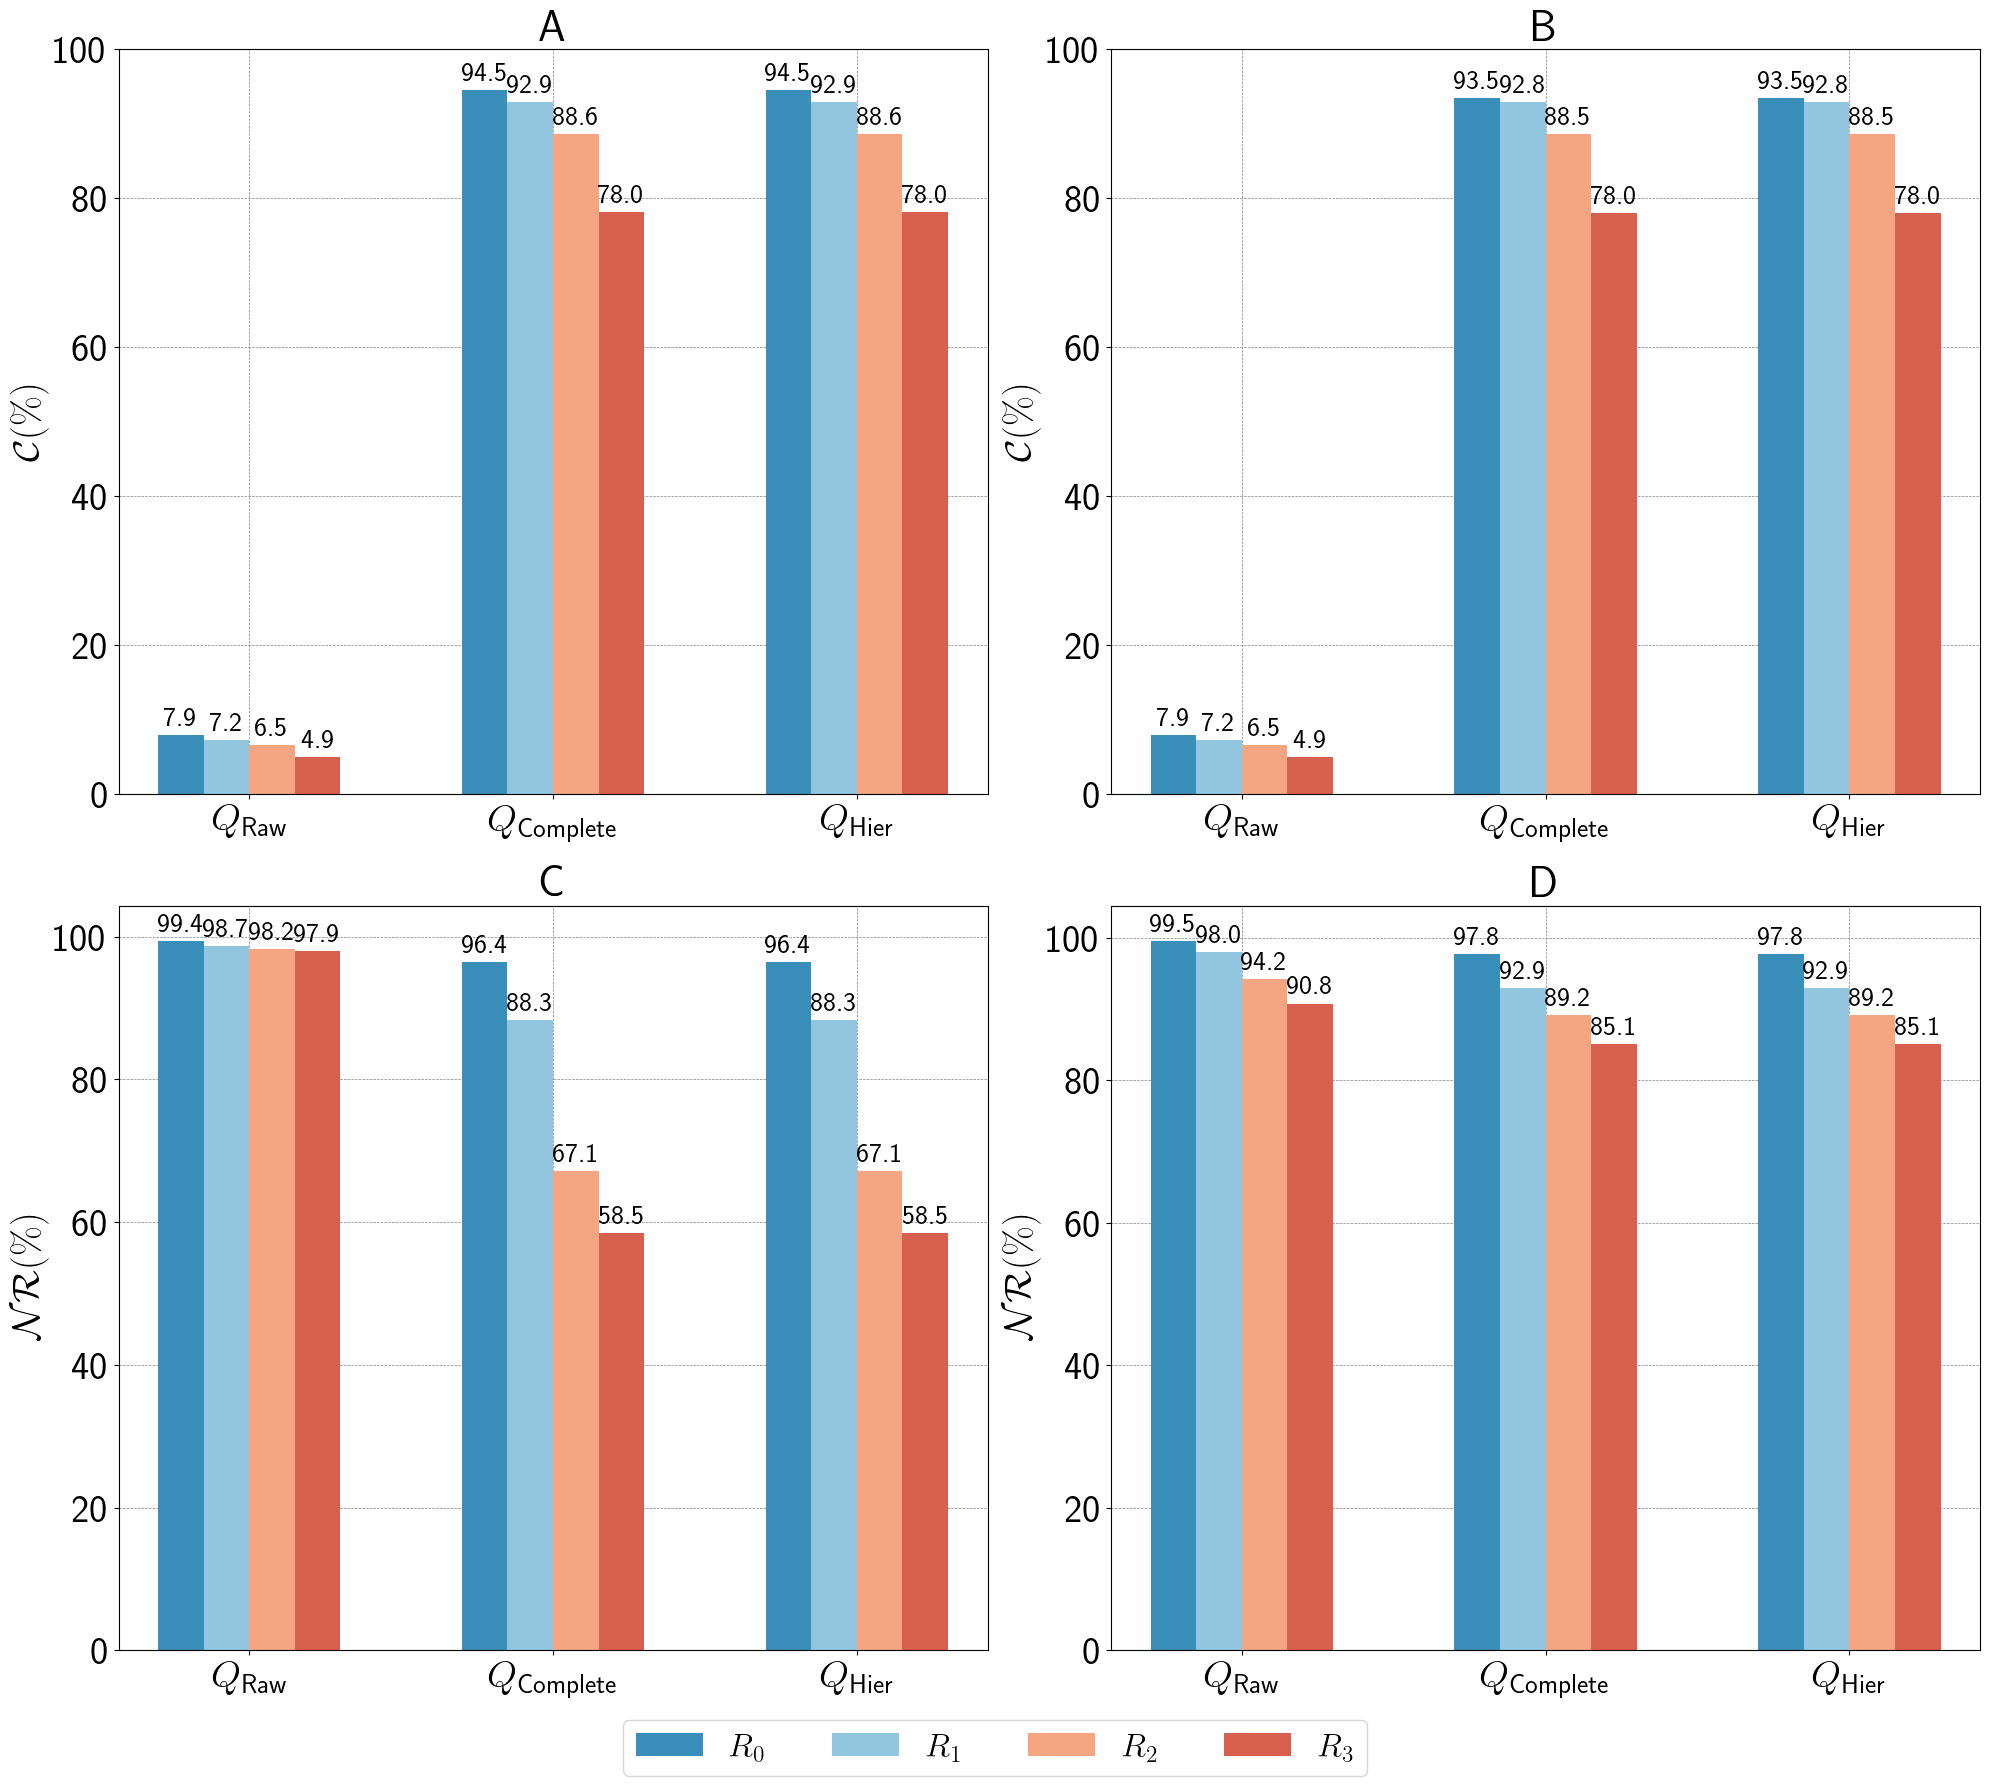

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Creating the figure and subplots
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")  # Ensure amsmath is loaded
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 18))
fontsettings = {
    "title_size": 32,
    "label_size": 28,
    "ticks_size": 28,
    "annotation_size": 20,
}

# Plotting data
plot_percentage(fw, ax1, "C", title=r"A", fontsettings=fontsettings)
plot_percentage(bw, ax2, "C", title=r"B", fontsettings=fontsettings)

plot_percentage(fw, ax3, "NR", title=r"C", fontsettings=fontsettings)
plot_percentage(bw, ax4, "NR", title=r"D", fontsettings=fontsettings)


fig.legend(
    [r"$R_0$", r"$R_1$", r"$R_2$", r"$R_3$"],  # Correct LaTeX formatted strings
    loc="lower center",
    ncol=4,
    fontsize=24,
    bbox_to_anchor=(0.5, 0.001),
)

# Adjusting layout
fig.tight_layout()
fig.subplots_adjust(hspace=0.15, bottom=0.08)
# fig.savefig(
#     "./fig/Fig10_template_false_rate_compare_valid.pdf",
#     dpi=600,
#     bbox_inches="tight",
#     pad_inches=0,
# )

## 3. ROC curve

In [ ]:
import sys
import pandas as pd
import numpy as np

sys.path.append("../../")
from _analysis._rule_app_analysis import load_results_from_json

results = load_results_from_json("../../Data/Temp/Benchmark/raw_results.json")

valid = results["Valid"]

valid_fw = valid["fw"]
valid_bw = valid["bw"]
fw = pd.DataFrame(valid_fw).T
bw = pd.DataFrame(valid_bw).T
fw.rename(
    columns={
        0: "average_solution",
        # 1: r'\mathcal(C)',
        1: "C",
        2: "NR",
    },
    inplace=True,
)
bw.rename(
    columns={
        0: "average_solution",
        # 1: r'\mathcal(C)',
        1: "C",
        2: "NR",
    },
    inplace=True,
)

fw[["Type", "Radii"]] = fw.index.to_series().str.split("_", expand=True)
bw[["Type", "Radii"]] = bw.index.to_series().str.split("_", expand=True)

In [ ]:
def plot_roc_curves(
    df: pd.DataFrame,
    ax: plt.Axes,
    selected_types: Optional[List[str]] = None,
    fontsettings: Optional[Dict[str, int]] = None,
    title: str = "A",
    add_legend: bool = False,
) -> List[Any]:
    """
    Plot ROC curves for specified types from a DataFrame on a given matplotlib Axes.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data for plotting. Must include columns 'Type', 'C' for TPR,
                       and 'FPR' for FPR, where 'Type' differentiates data series.
    ax (plt.Axes): The matplotlib Axes object where the ROC curves will be drawn.
    selected_types (Optional[List[str]]): List of strings representing the types to be included in the plot.
                                          If None, all types in the DataFrame will be plotted.
    fontsettings (Optional[Dict[str, int]]): Dictionary containing font settings for titles, labels,
                                             ticks, and annotations. If None, defaults will be applied.
    title (str): Title of the plot.
    add_legend (bool): If True, add a legend to the plot.

    Returns:
    List[Any]: List containing matplotlib line handles for the legend, useful if further customization
               or reference is needed.

    Raises:
    ValueError: If selected_types is provided and contains non-string elements.

    Example:
    >>> fig, ax = plt.subplots()
    >>> data = pd.DataFrame({
    ...     'Type': ['Type1', 'Type1', 'Type2', 'Type2'],
    ...     'C': [90, 85, 88, 80],
    ...     'FPR': [5, 10, 5, 10]
    ... })
    >>> plot_roc_curves(data, ax, ['Type1', 'Type2'])
    >>> plt.show()
    """
    if selected_types is not None:
        if not all(isinstance(t, str) for t in selected_types):
            raise ValueError("selected_types must be a list of strings.")
        original_types = [t for t in selected_types if t in df["Type"].unique()]
    else:
        original_types = df["Type"].unique()

    types = [f"$Q_{{\\text{{{t}}}}}$" for t in original_types]

    if fontsettings is None:
        fontsettings = {
            "title_size": 28,
            "label_size": 24,
            "ticks_size": 24,
            "annotation_size": 18,
        }

    markers = ["o", "^", "s", "p"]
    markers.reverse()
    marker_labels = [r"$R_{0}$", r"$R_{1}$", r"$R_{2}$", r"$R_{3}$"]
    marker_labels.reverse()
    marker_color = "gray"

    colors = plt.cm.coolwarm(np.linspace(0, 1, len(types)))
    colors = ["#3A8EBA", "#D6604D"]
    legend_handles = []

    for index, type_ in enumerate(original_types):
        type_data = df[df["Type"] == type_]
        tpr = type_data["C"].tolist()
        fpr = type_data["NR"].tolist()
        tpr = [x / 100 for x in tpr]
        fpr = [x / 100 for x in fpr]
        tpr.reverse()
        fpr.reverse()

        (line,) = ax.plot(
            fpr, tpr, linestyle="-", color=colors[index], label=f"{types[index]}"
        )
        legend_handles.append(line)

        for i, (f, t) in enumerate(zip(fpr, tpr)):
            marker = ax.plot(
                f, t, marker=markers[i % len(markers)], color=marker_color
            )[0]
            if index == 1:
                marker_handle = plt.Line2D(
                    [0],
                    [0],
                    marker=markers[i % len(markers)],
                    color="none",
                    markerfacecolor=marker_color,
                    markersize=10,
                    label=marker_labels[i],
                )
                legend_handles.append(marker_handle)

    ax.set_xlabel(r"$\mathcal{NR}\ (\%)$", fontsize=fontsettings["label_size"])
    ax.set_ylabel(r"$\mathcal{C}\ (\%)$", fontsize=fontsettings["label_size"])
    ax.set_title(rf"{title}", fontsize=fontsettings["title_size"], weight="medium")
    ax.tick_params(axis="both", which="major", labelsize=fontsettings["ticks_size"])
    ax.grid(True)

    if add_legend:
        ax.legend(
            handles=legend_handles,
            loc="lower right",
            fancybox=True,
            title_fontsize=fontsettings["label_size"],
            fontsize=fontsettings["annotation_size"],
            ncol=3,
        )

    ax.grid(True)
    return legend_handles

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# from _analysis._rule_app_analysis import plot_roc_curves

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")  # Ensure amsmath is loaded
fontsettings = {
    "title_size": 24,
    "label_size": 20,
    "ticks_size": 20,
    "annotation_size": 16,
}
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plot_roc_curves(
    fw,
    axs[0],
    selected_types=["Complete", "Refine"],
    fontsettings=fontsettings,
    title="A",
)
legend_handles = plot_roc_curves(
    bw,
    axs[1],
    selected_types=["Complete", "Refine"],
    fontsettings=fontsettings,
    title="B",
)

fig.legend(
    handles=legend_handles,
    loc="lower center",
    fancybox=True,
    title_fontsize=fontsettings["label_size"],
    fontsize=fontsettings["annotation_size"],
    ncol=3,
    bbox_to_anchor=(0.5, 0.001),
)

fig.tight_layout()
fig.subplots_adjust(hspace=0.15, wspace=0.2, bottom=0.2)
# fig.savefig("./fig/ROC_test.pdf", dpi=600, bbox_inches="tight", pad_inches=0)

## G-mean

In [ ]:
import sys
import pandas as pd
import numpy as np

sys.path.append("../../")
from _analysis._rule_app_analysis import load_results_from_json

results = load_results_from_json("../../Data/Temp/Benchmark/raw_results.json")

valid = results["Valid"]

valid_fw = valid["fw"]
valid_bw = valid["bw"]
fw = pd.DataFrame(valid_fw).T
bw = pd.DataFrame(valid_bw).T
fw.rename(
    columns={
        0: "AG",
        # 1: r'\mathcal(C)',
        1: "C",
        2: "NR",
    },
    inplace=True,
)
bw.rename(
    columns={
        0: "AG",
        # 1: r'\mathcal(C)',
        1: "C",
        2: "NR",
    },
    inplace=True,
)

fw[["Type", "Radii"]] = fw.index.to_series().str.split("_", expand=True)
bw[["Type", "Radii"]] = bw.index.to_series().str.split("_", expand=True)

In [ ]:
def gmean(tpr, fpr):
    tnr = 1 - fpr  # True Negative Rate
    g_mean = (tpr + tnr) / 2
    return g_mean


# Calculate G-mean for each row and add it as a new column
fw["Sc-forward"] = fw.apply(lambda row: gmean(row["C"] / 100, row["NR"] / 100), axis=1)
bw["Sc-backward"] = bw.apply(lambda row: gmean(row["C"] / 100, row["NR"] / 100), axis=1)

In [ ]:
fw

In [ ]:
valid_result = pd.concat(
    [fw["Sc-forward"], bw[["Sc-backward", "Type", "Radii"]]], axis=1
)

In [ ]:
valid_result

In [ ]:
test_result = pd.concat(
    [fw["G-mean-forward"], bw[["G-mean-backward", "Type", "Radii"]]], axis=1
)

In [ ]:
def gmean(tpr, fpr):

    tnr = 1 - fpr  # True Negative Rate

    g_mean = np.sqrt(tpr * fpr)
    return g_mean


# Calculate G-mean for each row and add it as a new column
fw["G-mean"] = fw.apply(lambda row: gmean(row["C"] / 100, row["AG"] / 100), axis=1)
bw["G-mean"] = bw.apply(lambda row: gmean(row["C"] / 100, row["AG"] / 100), axis=1)

In [ ]:
g_mean_results = {}

for type_, group in fw.groupby("Type"):
    tpr = (
        group["C"] / 100
    )  # True Positive Rate (C is already in percentage, so divide by 100)
    fpr = group["FPR"] / 100  # False Positive Rate
    tnr = 1 - fpr  # True Negative Rate
    g_mean = np.sqrt(tpr * tnr).mean()  # Geometric Mean
    g_mean_results[type_] = g_mean

# Output the G-mean results for each Type
g_mean_results

## 4. Time processing

In [ ]:
from datetime import datetime


def calculate_time_difference(log_file_path):
    # Define the time format from the logs
    time_format = "%Y-%m-%d %H:%M:%S,%f"

    # Initialize variables to store timestamps
    start_time = None
    end_time = None

    # Open and read the log file
    with open(log_file_path, "r") as file:
        for line in file:
            # Check if line contains the start process timestamp
            if "Start process" in line:
                timestamp_str = line.split(" - ")[0]
                start_time = datetime.strptime(timestamp_str, time_format)

            # Check if line contains the forward prediction validation timestamp
            elif "Save Successfully" in line:
                timestamp_str = line.split(" - ")[0]
                end_time = datetime.strptime(timestamp_str, time_format)

    # Ensure both timestamps are found
    if start_time is None or end_time is None:
        raise ValueError(
            "Timestamps for 'Start process' or 'Forward Prediction Validation' not found in the log file."
        )

    # Calculate the time difference
    time_difference = end_time - start_time
    total_seconds = time_difference.total_seconds()

    return total_seconds


# Example usage
log_file_path = "../../Data/Temp/Benchmark/Hier/Log/Test"

In [ ]:
radius = [0, 1, 2, 3]
result = []
for i in radius:
    try:
        total_seconds = calculate_time_difference(
            log_file_path=f"{log_file_path}/r{i}.txt"
        )
        result.append(total_seconds)
    except:
        result.append(None)

In [ ]:
result

In [ ]:
valid_times_compare = {
    r"$Q_{\text{raw}}$": [15046.681, 32158.483, 154044.789, 430495.183],
    r"$Q_{\text{complete}}$": [7488.947, 20696.089, 160297.79, 384013.142],
    r"$Q_{\text{hier}}$": [7695.527, 7877.95, 11179.153, 12264.814],
}

In [ ]:
test_times_compare = {
    r"$Q_{\text{raw}}$": [12927.806, 24830.483, 135851.743, 420144.058],
    r"$Q_{\text{complete}}$": [6813.398, 20023.909, 193788.516, 411546.561],
    r"$Q_{\text{hier}}$": [7121.137, 8230.713, 10776.668, 11963.403],
}

In [ ]:
def convert_seconds_to_hours(times_dict):
    return {
        key: [round(value / 3600, 2) for value in values]
        for key, values in times_dict.items()
    }


valid_times_compare = convert_seconds_to_hours(valid_times_compare)
valid_times_compare

In [ ]:
test_times_compare = convert_seconds_to_hours(test_times_compare)
test_times_compare

In [ ]:
from _analysis._rule_app_analysis import plot_processing_times

In [ ]:
import matplotlib.pyplot as plt
from typing import *
import seaborn as sns
import numpy as np
import pandas as pd


def plot_processing_times(
    times: Dict[str, List[float]], ax: Optional[plt.Axes] = None, title: str = "A"
) -> None:
    """
    Plot processing times for various methods across different stages.

    This function takes a dictionary of processing times, converts them into hours,
    and plots them using a bar chart.

    Parameters:
    times (Dict[str, List[float]]): A dictionary where keys are method names and values
                                    are lists of processing times in seconds for each stage.
    ax (Optional[plt.Axes]): Matplotlib Axes object where the plot will be drawn. If None,
                             the current active Axes will be used.
    title (str): The title of the plot.

    Returns:
    None: The function creates a plot but does not return any value.

    Example:
    >>> times = {
    ...     "Method1": [3600, 7200, 1800, 5400],
    ...     "Method2": [1800, 3600, 900, 2700],
    ... }
    >>> fig, ax = plt.subplots()
    >>> plot_processing_times(times, ax=ax, title="Processing Times Analysis")
    >>> plt.show()
    """
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"\usepackage{amsmath}")  # Ensure amsmath is loaded
    # Convert to hours
    for key in times:
        times[key] = np.array(times[key]) / 3600

    # Stages
    stages = [r"$R_{0}$", r"$R_{1}$", r"$R_{2}$", r"$R_{3}$"]

    # Create a DataFrame
    df = (
        pd.DataFrame(times, index=stages)
        .reset_index()
        .melt(id_vars="index", var_name="Method", value_name="Time (hours)")
    )
    df.rename(columns={"index": "Stage"}, inplace=True)

    # Create the plot on the provided ax
    if ax is None:
        ax = plt.gca()  # Get current axis if not provided

    custom_colors = ["#5e4fa2", "#3A8EBA", "#D6604D"]
    palette = sns.color_palette(custom_colors[: len(times.keys())])
    bar_plot = sns.barplot(
        x="Stage", y="Time (hours)", hue="Method", data=df, palette=palette, ax=ax
    )

    ax.set_title(rf"{title}", fontsize=24, weight="bold")
    ax.set_xlabel(None)
    ax.set_ylabel(rf"Time (Hours)", fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    ax.set_yticklabels([rf"{y:.0f}" for y in ax.get_yticks()], fontsize=20)
    ax.legend(
        title="Template Type",
        title_fontsize="24",
        fontsize="20",
        loc="upper left",
        bbox_to_anchor=(0.01, 1),
    )

    # Add text annotations on the bars
    for p in bar_plot.patches:
        bar_height = p.get_height()
        if bar_height > 0.01:  # Adjust this threshold as needed
            annotation = format(
                p.get_height(), ".1f" if p.get_height() < 100 else ".0f"
            )
            ax.annotate(
                rf"{annotation}",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center",
                va="center",
                xytext=(0, 9),
                textcoords="offset points",
                fontsize=20,
            )

    ax.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt

plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"\usepackage{amsmath}")  # Ensure amsmath is loaded
fig, axs = plt.subplots(1, 1, figsize=(16, 8))
plot_processing_times(valid_times_compare, ax=axs, title="A. Time benchmarking")
# plot_processing_times(test_times_compare, ax=axs[1], title = 'B')
# fig.savefig('../../time_process_rule', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plot_processing_times(valid_times_compare, ax=axs[0], title="A. Validation set")
plot_processing_times(test_times_compare, ax=axs[1], title="B. Test set")
fig.savefig(
    "../../Docs/Analysis/fig/Fig11_time_process_benchmark.pdf",
    bbox_inches="tight",
    pad_inches=0,
    dpi=600,
)